# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 展示特徵篩選的作法

# [範例重點]
- 觀察相關係數過濾法的寫作方式(In[2], Out[2], In[4], Out[4]), 以及對線性迴歸與梯度提升機有什麼影響 (In[5]~In[8], Out[5]~Out[8]) 
- 觀察L1 嵌入法的寫作方式(In[9]~In[11], Out[9]~Out[11]), 以及對線性迴歸與梯度提升機有什麼影響 (In[12], Out[12], In[13], Out[13]) 

In [13]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'house_train.csv')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


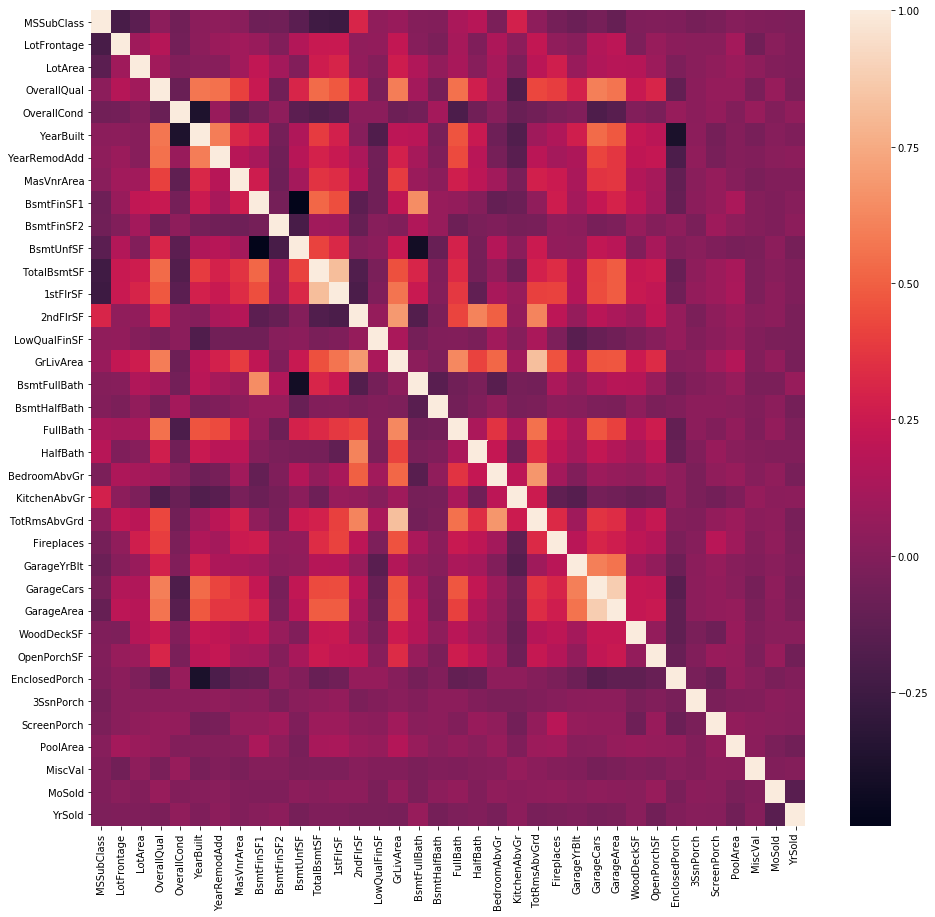

In [36]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
plt.figure(figsize=(16,15))
sns.heatmap(corr)
plt.show()

In [15]:
# 記得刪除 SalePrice
df = df.drop(['SalePrice'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [16]:
# 篩選相關係數大於 0.1 或小於 -0.1 的特徵
high_list = list(corr[(corr['SalePrice']>0.1) | (corr['SalePrice']<-0.1)].index)
high_list.pop(-1)   #用于移除列表中的一个元素（默认最后一个元素），并且返回该元素的值。 因為要把 SalePrice 刪除(最後一個元素)
print(high_list)

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


In [17]:
# 原始特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.846643681071632

In [18]:
# 高相關性特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8288821541594242

In [19]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8860567378041834

In [20]:
# 高相關性特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8736157558562272

In [22]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.001)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.12408194, -0.        ,  0.        ,  0.81411198,  0.2970946 ,
        0.33007182,  0.08851589,  0.        ,  0.04287006,  0.        ,
       -0.        ,  0.17513694,  0.11086056,  0.        , -0.        ,
        0.87326328,  0.2040765 ,  0.        ,  0.10285172,  0.03174629,
        0.        , -0.        ,  0.12246045,  0.17953898,  0.01851559,
        0.27672243,  0.03230955,  0.09061659,  0.        ,  0.        ,
        0.        ,  0.09550047, -0.        , -0.        ,  0.        ,
       -0.01874705])

In [32]:
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))

df.columns[L1_mask]

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'YrSold'],
      dtype='object')

In [33]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch',
 'YrSold']

In [34]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8475901403725674

In [35]:
# L1_Embedding 特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8833799048533908

# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?